In [2]:
from lmfit import minimize, Parameters # Parameter, report_fit

In [3]:
import numpy as np
import xsimlab as xs
from scipy.integrate import odeint
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = [15, 10]

# ASTroCAT

(Allometric/Stochastic Trophic Complexity Analysis Tool)

This is a model presented by Neil Banas in the publication:
Banas, N. S. (2011). Adding complex trophic interactions to a size-spectral plankton model: Emergent diversity patterns and limits on predictability. Ecological Modelling, 222(15), 2663–2675. https://doi.org/10.1016/j.ecolmodel.2011.05.018

The basic implementation represents a 

The model, named ASTroCAT (Allometric/Stochastic Trophic Complexity Analysis Tool), is schematized in Fig. 1. It uses nitrogen as its currency (stocks are reported in units of µmol N m−3, or µM), with compartments for dissolved nutrients (N), 40 size classes of phytoplankton (P), and 40 classes of small zooplankton (Z). The ver- sion used here has been kept mechanistically minimal, containing only a single bottom-up control (nutrient limitation of P growth), a single top-down control (higher predation on Z), and one highly resolved level of trophic interactions (P–Z) in between. There is no light or temperature dependence to P growth, and no distinction made between the rate and timing of phytoplankton cell growth and the rate and timing of uptake of the limiting nutrient. The physical testbed is a single box, and the detrital pool and regeneration pathways are not tracked: mortality and zooplankton egestion (sloppy feeding) are treated as losses from the model nitrogen pool, and whatever fraction of these losses is ultimately regenerated is folded into an imposed, external nutrient supply (S). Thus the model can be thought of as an “open” or “flowthrough” NPZ system, as opposed to the classical “closed” NPZ system (Franks, 2002), which sends mortality and egestion losses directly back into the N pool. The minimalism of this model configuration makes the interpretation of results easier, but for a realistic application, one would, at a minimum, add light-dependence to phytoplankton growth, resolve at least one spatial dimension in the domain, and explicitly track detritus. 

The model equations are

In [ ]:
# get file onto server, or start working back in home repo!

In [5]:
@xs.process
class UniqueComponent:
    """This is for initializing a Nutrient (i.e. components that are unique (0D))"""
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    
    def initialize(self):
        self.label = (self.component_label,)
        self.init = np.array(self.initVal)
        print('NutInit',self.init)
        

In [6]:
@xs.process
class Nutrient(UniqueComponent):
    component_label = xs.variable(default='N', groups='component-label')
    initVal = xs.variable(default=1)
    supplyrate = xs.variable(default=1)

    # Process variables
    supply = xs.variable(intent='out')
    
    def _supply(self):
        return self.supplyrate
    
    def initialize(self):
        super(Nutrient, self).initialize()
        self.supply = self._supply

In [7]:
@xs.process
class FlexSizeComponent:
    """This is for initializing both Phytoplankton and Zooplankton (i.e. components of variable number (1D))"""
    #flux = xs.variable(intent='out', groups='flux')
    label = xs.variable(intent='out', groups='label')
    init = xs.variable(intent='out', groups='init')
    size = xs.variable(intent='out', groups='size')
        
    def calculate_sizes(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize_alloparams(self):
        # must be implemented in subclasses
        raise NotImplementedError
        
    def initialize(self):
        self.label = tuple((self.component_label + str(i) for i in range(self.NP)))
        self.init = np.array([self.initVal / self.NP for i in range(self.NP)])
        
        self.size = self.calculate_sizes()

        self.initialize_alloparams()

In [8]:
@xs.process
class Phytoplankton(FlexSizeComponent):
    component_label = xs.variable(default='P', groups='component-label')
    # Phytoplankton params
    PMinEsd = xs.variable(default = 1,  description='P max growth', groups='parameter', static=True)
    PMaxEsd = xs.variable(default = 20, description='P max growth', groups='parameter', static=True)
    NP =      xs.variable(default = 40, description='number of P',  groups='parameter', static=True)
    
    # INPUT
    initVal = xs.variable()
    m = xs.variable(default=.1)
    
    # Rate params
    ks = xs.variable(intent='out', description='allometric half-saturation constant',  groups='parameter')
    mu0 = xs.variable(intent='out', description='allometric growth rate',  groups='parameter')
    
    # Process variables
    uptake = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    grazed = xs.variable(intent='out')
    
    def _uptake(self, N):
        return self.mu0 * N / (N + self.ks)
    
    def _mortality(self):
        """returns size-scaled mortality rate, calculated from mu0"""
        return self.m * self.mu0 
    
    def _grazed(self,FgrazP):
        return [sum(FgrazP[i,:]) for i in range(self.NP)]
    
    
    def calculate_sizes(self):
        numbers = np.array([i for i in range(self.NP)])
        sizes = (np.log(self.PMaxEsd) - np.log(self.PMinEsd))* numbers / (self.NP-1) + np.log(self.PMinEsd)
        return np.exp(sizes)
    
    def initialize_alloparams(self):
        # must be implemented in subclasses
        self.mu0 = (self.size) ** -0.45
        self.ks = (self.size) * .1
        
    def initialize(self):
        super(Phytoplankton, self).initialize()
        self.uptake = self._uptake
        self.mortality = self._mortality
        self.grazed = self._grazed


In [9]:
@xs.process
class Zooplankton(FlexSizeComponent):
    component_label = xs.variable(default='Z', groups='component-label')
    # SetupParams
    PMinEsd = xs.foreign(Phytoplankton, 'PMinEsd')
    PMaxEsd = xs.foreign(Phytoplankton, 'PMaxEsd')
    NP =      xs.foreign(Phytoplankton, 'NP')
    phytosize = xs.foreign(Phytoplankton, 'size')
   
    # Zooplankton params 
    initVal = xs.variable()
    zeta = xs.variable(default=1) #mortality rate quadratic
    deltaxprey = xs.variable(default=0.25) # log10 prey size tolerance
    KsZ = xs.variable(default=3) # grazing half saturation constant
    f_eg = xs.variable(default=.33) # egested food
    epsilon = xs.variable(default=.33) # assimilated food
    
    
    # Alloparams
    I0 = xs.variable(intent='out')
    xpreyopt = xs.variable(intent='out')
    
    phiP = xs.variable(intent='out')
    
    # Process variables
    grazingmatrix = xs.variable(intent='out')
    mortality = xs.variable(intent='out')
    ingestion = xs.variable(intent='out')
    excretion = xs.variable(intent='out')
    
    def _grazingmatrix(self,P,Z):
        PscaledAsFood = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):
                PscaledAsFood[i,j] = self.phiP[i,j] / self.KsZ * P[i]
        
        FgrazP = np.zeros((self.NP,self.NP))
        for j in range(self.NP):
            for i in range(self.NP):        
                FgrazP[i,j] = self.I0[j] * Z[j] * PscaledAsFood[i,j] / (1 + sum(PscaledAsFood[:,j]))
                
        return FgrazP
    
    def _ingestion(self,FgrazP):
        return [self.epsilon * sum(FgrazP[:,j]) for j in range(self.NP)]

    def _excretion(self,FgrazP):
        return [(1 - self.f_eg - self.epsilon) * sum(FgrazP[:,j]) for j in range(self.NP)]
    
    def _mortality(self,Z):
        return self.zeta * sum(Z)
        
    def calculate_sizes(self):
        zoosizes= 2.16 * self.phytosize ** 1.79
        return zoosizes
    
    def initialize_alloparams(self):
        # initializes allometric parameters as lists, based on sizes
        self.I0 = 26 * (self.size) ** -0.4
        self.xpreyopt = 0.65 * (self.size) ** .56 
    
    def init_phiP(self):
        """creates array of feeding preferences [P...P10] for each [Z]"""
        phiP= np.array([[np.exp(-((np.log10(xpreyi)-np.log10(xpreyoptj)) / self.deltaxprey)**2) 
               for xpreyi in self.phytosize] for xpreyoptj in self.xpreyopt])
        return phiP
    
    def initialize(self):        
        super(Zooplankton, self).initialize()
        self.grazingmatrix = self._grazingmatrix
        
        self.mortality = self._mortality
        self.ingestion = self._ingestion
        self.excretion = self._excretion
        
        self.phiP = self.init_phiP()



In [10]:
import itertools

def flatten(generatorlist):
    # returns 1D list from nested generator or multi-D list
    return list(itertools.chain.from_iterable(generatorlist))

In [11]:
@xs.process
class Chemostat:
    # foreign processes
    N_supply = xs.foreign(Nutrient, 'supply')
    
    P_uptake = xs.foreign(Phytoplankton, 'uptake')
    P_mortality = xs.foreign(Phytoplankton, 'mortality')
    
    grazingmatrix = xs.foreign(Zooplankton, 'grazingmatrix')
    Z_ingestion = xs.foreign(Zooplankton, 'ingestion')
    Z_excretion = xs.foreign(Zooplankton, 'excretion')
    Z_mortality = xs.foreign(Zooplankton, 'mortality')
    P_grazed = xs.foreign(Phytoplankton, 'grazed')
    
    # model construct labels
    complabels = xs.group('component-label')
    labels = xs.group('label')
    inits = xs.group('init')
    
    # output variables
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0

        # This is one of those things I am not sure about, it makes sense to use dicts to store model state (to allow calling different components by labels)
            # BUT this can not be used (afaik) in a nice way as output for plotting later on in the model output xarray.. do you have any idea how to do that more nicely?
        self.state = {label:val for label,val in zip(self.complabels,self.inits)}

        # in order to have output to plot, I also create an array that contains all output:
            # i have to use flatten function (defined above) to make group generators one dimensional (FlexComponents are Lists, so generators return List of Lists)
            # there should be a better solution to this.. but it relates to how xs.group() works in this model setup
        self.stateout = np.concatenate([self.state[label] for label in flatten(self.complabels)], axis=None)
        
        self.component = [i for i in flatten(self.labels)]
    
    def ode(self, state, time, labels, timestep):
        N, P, Z = state['N'], state['P'], state['Z']
        
        #P[P < 0.01] = 0.011
        #Z[Z < 0.01] = 0.011
        
        PGrazed = self.grazingmatrix(P,Z)

        dNdt = self.N_supply() - sum(self.P_uptake(N)*P) + sum(self.Z_excretion(PGrazed))
        
        dPdt = self.P_uptake(N)*P - self.P_mortality()*P - self.P_grazed(PGrazed)
        
        dZdt =  self.Z_ingestion(PGrazed) - self.Z_mortality(Z)*Z 
        
        # need to convert fluxes to correct time step by multiplying by dt        
        return {'N':dNdt*timestep, 'P':dPdt*timestep, 'Z':dZdt*timestep}

    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        self.outflux = self.ode(self.state,self.time,self.labels, dt)
        # {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.complabels}
        
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.complabels}
        
        self.stateout = np.concatenate(flatten([(self.state[label] for label in self.complabels)]), axis=None)



In [12]:
modmod = xs.Model({'env':Chemostat, 'N':Nutrient, 'P':Phytoplankton, 'Z':Zooplankton})

In [32]:
mom_in = xs.create_setup(
        model=modmod,
    clocks={
         'time': np.linspace(1,365,500*365)  # 20,1000)
     },
    input_vars={
        'P__initVal':1,
        'Z__initVal':1
    },
    output_vars={
        'env__component': None,
        'env__stateout': 'time'
    }
)

In [ ]:
mom_out = mom_in.xsimlab.run(model=modmod)

NutInit 1


In [ ]:
mom_out

In [ ]:
mom_out.to_netcdf('ASTroCAT_1y_x500res.nc')

In [17]:
mom_out4 = mom_out.set_index(component = 'env__component')

In [17]:
#mom_out2 = mom_out.set_index(component = 'env__component')

In [17]:
plt.rcParams['figure.figsize'] = [10, 5]

In [18]:
mom_out2.env__stateout[:,0:40].plot.line(x='time')
plt.show()
mom_out3.env__stateout[:,0:40].plot.line(x='time')
plt.show()
mom_out4.env__stateout[:,0:40].plot.line(x='time')

#plt.savefig('output_P.pdf', bbox_inches='tight')

NameError: name 'mom_out2' is not defined

In [ ]:
mom_out2.env__stateout[:,40:80].plot.line(x='time')
plt.show()
mom_out3.env__stateout[:,40:80].plot.line(x='time')
plt.show()
mom_out4.env__stateout[:,40:80].plot.line(x='time')

#plt.savefig('output_Z.pdf', bbox_inches='tight')

In [ ]:
mom_out2.env__stateout[:,80].plot.line(x='time')
plt.show()
mom_out3.env__stateout[:,80].plot.line(x='time')
plt.show()
mom_out4.env__stateout[:,80].plot.line(x='time')


#plt.savefig('output_N.pdf', bbox_inches='tight')

In [608]:
@xs.process
class ModelSolver:
    labels = xs.group('label')
    init = xs.group('init')
    
    fluxes = xs.group('flux')
 
    component = xs.variable(dims=('component'), intent='out')
    
    state = xs.variable(dims=('component'),intent='out')
    stateout = xs.variable(dims=('component'),intent='out')
    outflux = xs.variable(dims=('component'),intent='out')
    
    def initialize(self):
        self.time = 0
        self.state = {label: val for label, val in zip(self.labels, self.init)}
        self.stateout = [self.state[label] for label in self.labels]
        self.funcs = {label: flux for label, flux in zip(self.labels, self.fluxes)}
        
        self.component = [i for i in self.labels]


    @xs.runtime(args='step_delta')
    def run_step(self,dt):
        # need to convert fluxes to correct time step by multiplying by dt
        self.outflux = {label : self.funcs[label](self.state, self.time, self.labels) * dt for label in self.labels}
        # keep track of timestep for forcing (+ other time dep. processes)
        self.time += dt
    
    def finalize_step(self):
        self.state = {label : self.state[label] + self.outflux[label] for label in self.labels}
        self.stateout = [self.state[label] for label in self.labels]
        #print(self.state)

In [609]:
# This should be the ideal setup way:
flextestModelSetup = xs.Model({'MS':ChemostatParameters,
                               'N1':Nutrient, 
                               'P1':Phytoplankton, 'P2':Phytoplankton, 'P3':Phytoplankton, 
                               'ModelSolver':ModelSolver})

NameError: name 'ChemostatParameters' is not defined

In [610]:
#flextestModelSetup.all_vars_dict

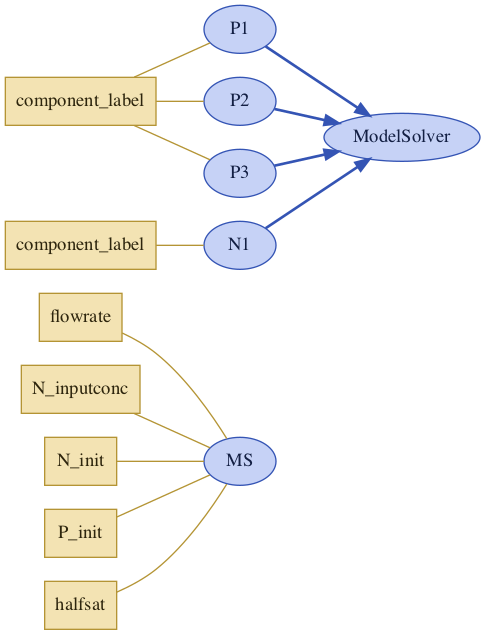

In [51]:
flextestModelSetup.visualize(show_inputs=True)

In [52]:
# this is one way to create an lmfit.Parameter object:
parameters = Parameters()

parameters.add('MS__N_init', value=1,  vary=False)
parameters.add('MS__P_init', value=0.1, vary=False)

parameters.add('MS__N_inputconc', value=2,  vary=False)
parameters.add('MS__flowrate', value=0.2,  vary=False)
parameters.add('MS__halfsat', value=0.5,  vary=False)

In [53]:
def parameterDict2Input_vars(params):
    params = {key : value for key, value in params.valuesdict().items()} 
    
    return params

In [54]:
parameterDict2Input_vars(parameters)

{'MS__N_init': 1,
 'MS__P_init': 0.1,
 'MS__N_inputconc': 2,
 'MS__flowrate': 0.2,
 'MS__halfsat': 0.5}

In [55]:
flextestModelSetup_in = xs.create_setup(
 model=flextestModelSetup,
    clocks={
         'time': np.linspace(0,20,1000)
     },
    
    input_vars = parameterDict2Input_vars(parameters),
    
    output_vars={
        'ModelSolver__component' : None,
        'ModelSolver__stateout'  : 'time',
        'ModelSolver__outflux': 'time'
    }
    
)

In [56]:
component_num = 1
out = flextestModelSetup_in.xsimlab.run(model=flextestModelSetup)

In [57]:
out2 = out.set_index(component='ModelSolver__component')

In [58]:
out2

<xarray.Dataset>
Dimensions:                (component: 4, time: 1000)
Coordinates:
  * time                   (time) float64 0.0 0.02002 0.04004 ... 19.98 20.0
  * component              (component) object 'N1' 'P2' 'P3' 'P4'
Data variables:
    P3__component_label    <U1 'P'
    P1__component_label    <U1 'P'
    N1__component_label    <U1 'N'
    P2__component_label    <U1 'P'
    MS__N_init             int64 1
    MS__P_init             float64 0.1
    MS__N_inputconc        int64 2
    MS__flowrate           float64 0.2
    MS__halfsat            float64 0.5
    ModelSolver__stateout  (time, component) float64 1.0 0.1 ... 0.6204 0.6204
    ModelSolver__outflux   (time) object {'N1': 0.0, 'P2': 0.0009342676009342675, 'P3': 0.0009342676009342675, 'P4': 0.0009342676009342675} ... {'N1': -4.753622309054897e-06, 'P2': 1.8627641981626635e-05, 'P3': 1.8627641981626635e-05, 'P4': 1.8627641981626635e-05}

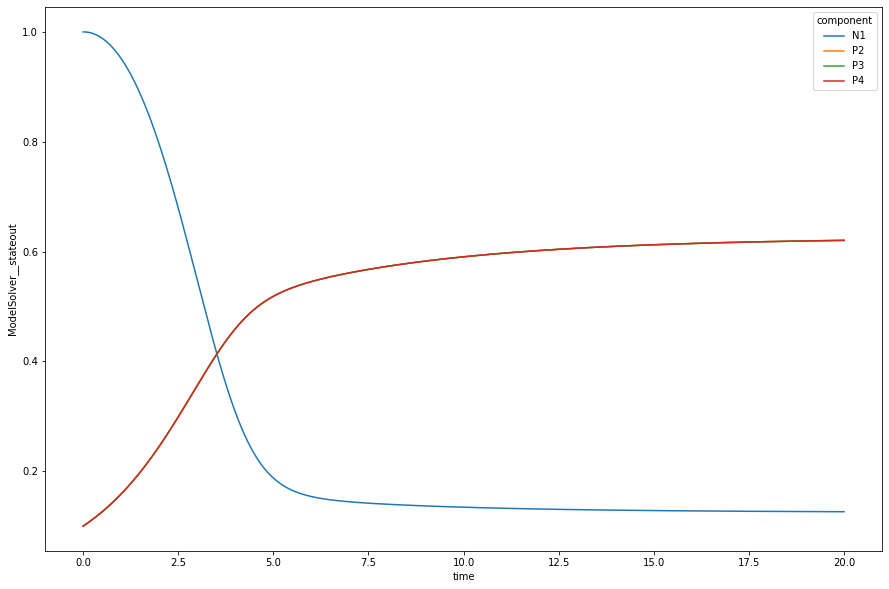

In [59]:
out2.ModelSolver__stateout.plot.line(x='time')